# Single step image generation using SDXL-turbo and OpenVINO

SDXL-Turbo is a fast generative text-to-image model that can synthesize photorealistic images from a text prompt in a single network evaluation. SDXL-Turbo is a distilled version of [SDXL 1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0), trained for real-time synthesis. 
SDXL Turbo is based on a novel distillation technique called Adversarial Diffusion Distillation (ADD), which enables the model to synthesize image outputs in a single step and generate real-time text-to-image outputs while maintaining high sampling fidelity. More details about this distillation approach can be found in [technical report](https://stability.ai/research/adversarial-diffusion-distillation). More details about model can be found in [Stability AI blog post](https://stability.ai/news/stability-ai-sdxl-turbo).

Previously, we already discussed how to launch Stable Diffusion XL model using OpenVINO in the following [notebook](../248-stable-diffusion-xl), in this tutorial we will focus on the [SDXL-turbo](https://huggingface.co/stabilityai/sdxl-turbo) version. Additionally, to improve image decoding speed, we will use [Tiny Autoencoder](https://github.com/madebyollin/taesd), which is useful for real-time previewing of the SDXL generation process.

We will use a pre-trained model from the [Hugging Face Diffusers](https://huggingface.co/docs/diffusers/index) library. To simplify the user experience, the [Hugging Face Optimum Intel](https://huggingface.co/docs/optimum/intel/index) library is used to convert the models to OpenVINO™ IR format.

## Prerequisites

In [ ]:
%pip uninstall -q -y openvino-dev openvino openvino-nightly
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu\
torch transformers diffusers "git+https://github.com/huggingface/optimum-intel.git" gradio openvino-nightly

## Convert model to OpenVINO format

[sdxl-turbo](https://huggingface.co/stabilityai/sdxl-turbo) is available for downloading via the [HuggingFace hub](https://huggingface.co/models). We will use optimum-cli interface for exporting it into OpenVINO Intermediate Representation (IR) format.

 Optimum CLI interface for converting models supports export to OpenVINO (supported starting optimum-intel 1.12 version).
General command format:

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
```

where task is task to export the model for, if not specified, the task will be auto-inferred based on the model. Available tasks depend on the model, for sdxl should be selected `stable-diffusion-xl` 

You can find a mapping between tasks and model classes in Optimum TaskManager [documentation](https://huggingface.co/docs/optimum/exporters/task_manager).

Additionally, you can specify weights compression `--fp16` for the compression model to FP16 and `--int8` for the compression model to INT8. Please note, that for INT8, it is necessary to install nncf.

Full list of supported arguments available via `--help`
For more details and examples of usage, please check [optimum documentation](https://huggingface.co/docs/optimum/intel/inference#export).

For Tiny Autoencoder, we will use `ov.convert_model` function for obtaining `ov.Model` and save it using `ov.save_model`. Model consists of 2 parts that used in pipeline separately:
`vae_encoder` for encoding input image in latent space in image-to-image generation task and `vae_decoder` that responsible for decoding diffusion result back to image format.

In [2]:
from pathlib import Path

model_dir = Path("./model")
sdxl_model_id = "stabilityai/sdxl-turbo"
tae_id = "madebyollin/taesdxl"
skip_convert_model = model_dir.exists()

In [3]:
import torch
import openvino as ov
from diffusers import AutoencoderTiny
import gc

class VAEEncoder(torch.nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, sample):
        return self.vae.encode(sample)
    
class VAEDecoder(torch.nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, latent_sample):
        return self.vae.decode(latent_sample)

def convert_tiny_vae(model_id, output_path):
    tiny_vae = AutoencoderTiny.from_pretrained(model_id)
    tiny_vae.eval()
    vae_encoder = VAEEncoder(tiny_vae)
    ov_model = ov.convert_model(vae_encoder, example_input=torch.zeros((1,3,512,512)))
    ov.save_model(ov_model, output_path / "vae_encoder/openvino_model.xml")
    tiny_vae.save_config(output_path / "vae_encoder")
    vae_decoder = VAEDecoder(tiny_vae)
    ov_model = ov.convert_model(vae_decoder, example_input=torch.zeros((1,4,64,64)))
    ov.save_model(ov_model, output_path / "vae_decoder/openvino_model.xml")
    tiny_vae.save_config(output_path / "vae_decoder")    
    

if not skip_convert_model:
    !optimum-cli export openvino --model $sdxl_model_id --task stable-diffusion-xl $model_dir --fp16
    convert_tiny_vae(tae_id, model_dir)

## Text-to-image generation

Text-to-image generation lets you create images using text description. To start generating images, we need to load models first.
To load an OpenVINO model and run an inference with Optimum and OpenVINO Runtime, you need to replace diffusers `StableDiffusionXLPipeline` with Optimum `OVStableDiffusionXLPipeline`. Pipeline initialization starts with using `from_pretrained` method, where a directory with OpenVINO models should be passed. Additionally, you can specify an inference device.

### Select inference device for text-to-image generation

In [4]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GNA', 'AUTO'), value='AUTO')

In [5]:
from optimum.intel.openvino import OVStableDiffusionXLPipeline
text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the vae_encoder to AUTO ...
Compiling the text_encoder to AUTO ...
Compiling the text_encoder_2 to AUTO ...


The pipeline interface is similar to original `StableDiffusionXLPipeline`. We should provide text prompt. The default number of steps is 50, while sdxl-turbo required only 1 step. According to the information provided in model card, model does not use negative prompt and guidance scale and this parameters should be disabled using  `guidance_scale = 0`

/home/ea/work/genai_env/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:565: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


  0%|          | 0/1 [00:00<?, ?it/s]

TImestep cond: None


/home/ea/work/genai_env/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:601: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)
/home/ea/work/genai_env/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:617: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


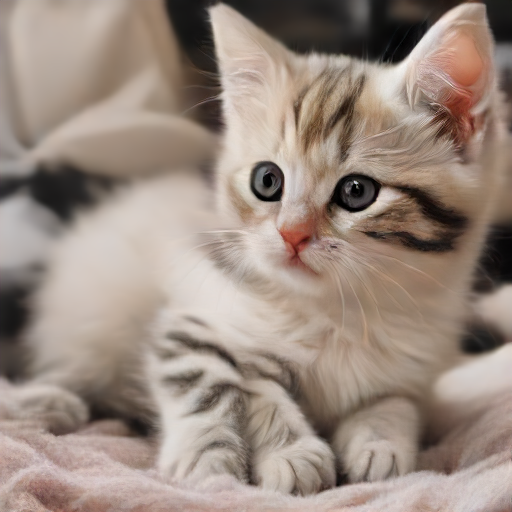

In [6]:
import numpy as np

prompt = "cute cat"
image = text2image_pipe(prompt, num_inference_steps=1, height=512, width=512, guidance_scale=0.0, generator=np.random.RandomState(987)).images[0]
image.save("cat.png")
image

In [7]:
del text2image_pipe
gc.collect();

## Image-to-Image generation

Image-to-image generation lets you transform images to match the characteristics provided in the text description. We can reuse the already converted model for running the Image2Image generation pipeline. For that, we should replace `OVStableDiffusionXLPipeline` with `OVStableDiffusionXLImage2ImagePipeline`.

In [8]:
from optimum.intel import OVStableDiffusionXLImg2ImgPipeline

image2image_pipe = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(model_dir, device=device.value)

Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the text_encoder to AUTO ...
Compiling the vae_encoder to AUTO ...


In [9]:
photo_prompt = "a cute cat with bow tie"

`strength` parameter is important for the image-to-image generation pipeline. It is a value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. Values that approach 1.0 enable lots of variations but will also produce images that are not semantically consistent with the input, then close to 0, less noise will be added and the target image will preserve source image content. strength has an impact not only on a number of noise but also the number of generation steps. The number of denoising iterations in the image-to-image generation pipeline is calculated as `int(num_inference_steps * strength)`. With sdxl-turbo we should be careful with selecting `num_inference_steps` and `strength` to produce the correct result and make sure that the number of steps used in pipeline >= 1 after applying strength multiplication. e.g. in example below, we will use `num_inference_steps=2` and `stength=0.5`, finally, we get 0.5 * 2.0 = 1 step in our pipeline.

/home/ea/work/genai_env/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:638: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


  0%|          | 0/1 [00:00<?, ?it/s]

TImestep cond: None


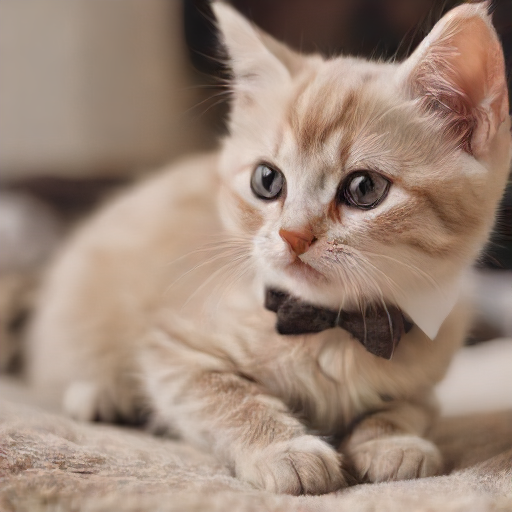

In [10]:
photo_image = image2image_pipe(photo_prompt, image=image, num_inference_steps=2, generator=np.random.RandomState(511), guidance_scale=0.0, strength=0.5).images[0]
photo_image.save("cat_tie.png")
photo_image

In [11]:
del image2image_pipe
gc.collect();

## Interactive Demo

Now, you can check model work using own text descriptions. Provide text prompt in the text box and launch generation using Run button. Additionally you can control generation with additional parameters:
* Seed - random seed for initialization
* Steps - number of generation steps
* Height and Width - size of generated image

> Please note that increasing image size may require to increasing number of steps for accurate result. We recommend running 104x1024 resolution image generation using 4 steps.

In [ ]:
import gradio as gr

text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)

def generate_from_text(text, seed, num_steps, height, width):
    result = text2image_pipe(text, num_inference_steps=num_steps, guidance_scale=0.0, generator=np.random.RandomState(seed), height=height, width=width).images[0]
    return result


with gr.Blocks() as demo:
    with gr.Column():
        positive_input = gr.Textbox(label="Text prompt")
        with gr.Row():
            seed_input = gr.Number(precision=0, label="Seed", value=42, minimum=0)
            steps_input = gr.Slider(label="Steps", value=1, minimum=1, maximum=4, step=1)
            height_input = gr.Slider(label="Height", value=512, minimum=256, maximum=1024, step=32)
            width_input = gr.Slider(label="Width", value=512, minimum=256, maximum=1024, step=32)
            btn = gr.Button()
        out = gr.Image(label="Result", type="pil", width=512)
        btn.click(generate_from_text, [positive_input, seed_input, steps_input, height_input, width_input], out)
        gr.Examples([
            ["cute cat", 999], 
            ["underwater world coral reef, colorful jellyfish, 35mm, cinematic lighting, shallow depth of field,  ultra quality, masterpiece, realistic", 89],
            ["a photo realistic happy white poodle dog ​​playing in the grass, extremely detailed, high res, 8k, masterpiece, dynamic angle", 1569],
            ["Astronaut on Mars watching sunset, best quality, cinematic effects,", 65245],
            ["Black and white street photography of a rainy night in New York, reflections on wet pavement", 48199]
        ], [positive_input, seed_input])

# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/
# if you want create public link for sharing demo, please add share=True
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)